# Table of Contents

1. [Imports](#imports)
   
4. [Dashboard](#dashboard)
   
   4.1  [Dashboard basics](#basic_dash)

   4.2  [ML Algorithms for Dashboard](#ml_dash)

   4.3  [Dash Elements](#ele_dash)

   4.4  [Dash Page 2: Machine Learning Diagnosis](#page2_dash)

   4.5  [Dash Page 1: Data Overview](#page1_dash)

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install category_encoders
!pip install scikit-learn
!pip install scikeras
!pip install keras
!pip install xgboost
!pip install scipy
!pip install imbalanced-learn
!pip install dash
!pip install dash-bootstrap-components
!pip install shap

# Imports <a id='imports'></a>

In [8]:
# General
import warnings 
warnings.filterwarnings('ignore', category=FutureWarning)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from imblearn.pipeline import Pipeline

# Kaggle API for dataset loading
from kaggle.api.kaggle_api_extended import KaggleApi

# Data Cleaning and Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster import hierarchy

# Machine Learning Models and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam, SGD
import xgboost as xgb

# Clustering Algorithms
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster import hierarchy

# Model Evaluation Metrics
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error, f1_score, roc_auc_score,
    precision_score, recall_score, accuracy_score, classification_report, confusion_matrix,
    roc_curve
)

# Cross-Validation and Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Dashboard Development
from dash import Dash, html, dcc, callback, Output, Input, dash_table
import dash_bootstrap_components as dbc

# SHAP for Model Interpretability
import shap

# Dashbord 
from dash import Dash, html, dcc, callback, Output, Input, dash_table
import dash_bootstrap_components as dbc
import matplotlib.patches as patches
import io
import base64
import plotly.express as px
import plotly.io as pio
import emoji

OSError: Could not find kaggle.json. Make sure it's located in C:\Users\Stella\.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/

# Dashboard <a id='dashboard'></a>

## Dashboard basics <a id='basic_dash'></a>

In [ ]:
## Dash colors

# Flatly-inspirierte Farbpalette
flatly_colors = {
    'background': '#ffffff',
    'text': '#2c3e50',
    'grid': '#ecf0f1',
    'accent1': "#895757",#'#18bc9c',
    'accent2': "#7ccdbd",#'#3498db'
     'light': '#F8F9FA',
    'dark': '#7B8A8B'
}

# Erstellen Sie ein benutzerdefiniertes Theme basierend auf Flatly
pio.templates['flatly_custom'] = pio.templates['plotly_white']
pio.templates['flatly_custom'].layout.update(
    font_color=flatly_colors['text'],
    paper_bgcolor=flatly_colors['background'],
    plot_bgcolor=flatly_colors['background'],
    colorway=[flatly_colors['accent1'], flatly_colors['accent2']]
)

# Aktualisieren Sie die Achsen
pio.templates['flatly_custom'].layout.xaxis.update(gridcolor=flatly_colors['grid'])
pio.templates['flatly_custom'].layout.yaxis.update(gridcolor=flatly_colors['grid'])


def show_color_palette(color_dict):
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_xlim(0, len(color_dict))
    ax.set_ylim(0, 1)
    ax.axis('off')

    for i, (name, color) in enumerate(color_dict.items()):
        rect = patches.Rectangle((i, 0), 1, 1, facecolor=color)
        ax.add_patch(rect)
        ax.text(i+0.5, -0.1, f'{name}\n{color}', ha='center', va='center')

    plt.show()

# Beispiel-Verwendung
flatly_colors = {
    'background': '#ffffff',
    'text': '#2c3e50',
    'grid': '#ecf0f1',
    'accent1': "#895757",
    'accent2': "#7ccdbd",
    'light': '#F8F9FA',
    'dark': '#7B8A8B'
}

show_color_palette(flatly_colors)

In [11]:
### Load dataset (see step 1)
df_cleaned = pd.read_csv("cancer_cleaned.csv")
X = df_cleaned.drop(['diagnosis'],axis = 1 )
y = df_cleaned['diagnosis']
df_cleaned.head()

,diagnosis,radius_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,area_se,radius_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst
0,1,17.99,122.80,1001.0,0.27760,0.3001,0.14710,1.0950,8.589,153.40,25.38,184.60,2019.0,0.6656,0.7119,0.2654
1,1,20.57,132.90,1326.0,0.07864,0.0869,0.07017,0.5435,3.398,74.08,24.99,158.80,1956.0,0.1866,0.2416,0.1860
2,1,19.69,130.00,1203.0,0.15990,0.1974,0.12790,0.7456,4.585,94.03,23.57,152.50,1709.0,0.4245,0.4504,0.2430
3,1,11.42,77.58,386.1,0.28390,0.2414,0.10520,0.4956,3.445,27.23,14.91,98.87,567.7,0.8663,0.6869,0.2575
4,1,20.29,135.10,1297.0,0.13280,0.1980,0.10430,0.7572,5.438,94.44,22.54,152.20,1575.0,0.2050,0.4000,0.1625


## ML Algorithms for the Dashboard <a id='ml_dash'></a>

### Function to pull out relevant metrics and plos for dashboard

In [128]:
# Function to pull out relevant metrics and plos for dashboard
#from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, roc_curve


def validate_model(y_test, y_pred, y_pred_proba, flatly_colors):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate metrics
    specificity = tn / (tn + fp)
    sensitivity = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Set the style to a clean, modern look
    plt.style.use('default')
    
    # Create confusion matrix plot
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', 
                cmap=[flatly_colors['light'], flatly_colors['dark']], 
                cbar=False, ax=ax)
    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_title('Confusion Matrix', fontweight='bold')
    
    # Customize the plot to match Flatly style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(colors=flatly_colors['text'])
    ax.xaxis.label.set_color(flatly_colors['text'])
    ax.yaxis.label.set_color(flatly_colors['text'])
    ax.title.set_color(flatly_colors['text'])
    
    # Save confusion matrix plot to a base64 string
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', facecolor=flatly_colors['background'])
    buffer.seek(0)
    confusion_matrix_plot = base64.b64encode(buffer.getvalue()).decode()
    plt.close()
    
    # Create ROC curve plot
    fig, ax = plt.subplots(figsize=(6, 4))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax.plot(fpr, tpr, color=flatly_colors['accent1'], lw=2, 
            label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color=flatly_colors['accent2'], lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontweight='bold')
    ax.set_title('Receiver Operating Characteristic', fontweight='bold')
    ax.legend(loc="lower right")
    
    # Customize the plot to match Flatly style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(colors=flatly_colors['text'])
    ax.xaxis.label.set_color(flatly_colors['text'])
    ax.yaxis.label.set_color(flatly_colors['text'])
    ax.title.set_color(flatly_colors['text'])
    ax.grid(color=flatly_colors['grid'], linestyle='--', alpha=0.7)
    
    # Save ROC curve plot to a base64 string
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', facecolor=flatly_colors['background'])
    buffer.seek(0)
    roc_curve_plot = base64.b64encode(buffer.getvalue()).decode()
    plt.close()
    
    # Return metrics and plot images
    return {
        'metrics': {
            'Specificity': specificity,
            'Sensitivity': sensitivity,
            'Precision': precision,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'ROC AUC': roc_auc
        },
        'confusion_matrix_plot': confusion_matrix_plot,
        'roc_curve_plot': roc_curve_plot
    }


In [130]:
# XGBOOST
# Uses: X,y
# Output: xgb_classifier, specificity_xgb, sensitivity_xgb, precision_xgb, accuracy_xgb, f1_xgb, roc_auc_xgb,  confusion_matrix_plot, roc_curve_plot


########################## DEFINE HYPERPARAMETERS HERE #################################################

n_estimators = 100
colsample_bytree = 0.8
learning_rate = 0.05
max_depth = 5
min_child_weight = 3
subsample = 0.9
gamma = 0.1
reg_alpha = 0
reg_lambda = 1

########################################################################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_classifier = xgb.XGBClassifier(
    n_estimators=n_estimators,
    colsample_bytree=colsample_bytree,
    learning_rate=learning_rate,
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    subsample=subsample,
    gamma=gamma,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    objective='binary:logistic',
    eval_metric='logloss'
)

xgb_classifier.fit(X_train_smote, y_train_smote)

y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

results_xgb = validate_model(y_test, y_pred, y_pred_proba, flatly_colors)

In [132]:
# RANDOM FOREST
# Uses: X,y
# Output: rf_classifier, specificity_rf, sensitivity_rf, precision_rf, accuracy_rf, f1_rf, roc_auc_rf,  confusion_matrix_plot, roc_curve_plot


########################## DEFINE HYPERPARAMETERS HERE #################################################

criterion = 'entropy'
n_estimators = 100
max_depth = 15
min_samples_split = 2
min_samples_leaf = 1
max_features = 'sqrt'

########################################################################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    random_state=42
)

rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

results_rf = validate_model(y_test, y_pred, y_pred_proba, flatly_colors)

In [134]:
# NEURAL NETWORK
# Uses: X,y
# Output: sq_model, specificity_sq, sensitivity_sq, precision_sq, accuracy_sq, f1_sq, roc_auc_sq,  confusion_matrix_plot, roc_curve_plot

########################## DEFINE HYPERPARAMETERS HERE #################################################

n_layers = 2 
n_neurons = 200 
activation = 'sigmoid'  
learning_rate = 0.001  
dropout_rate = 0.2  
optimizer_choice = 'adam'  
batch_size = 16 

########################################################################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

n_cols = X.shape[1]

sq_model = Sequential()
sq_model.add(Dense(n_neurons, activation=activation, input_shape=(n_cols,)))
for i in range(n_layers - 1):
    sq_model.add(Dense(n_neurons, activation=activation))
    sq_model.add(Dropout(dropout_rate))
    sq_model.add(Dense(1, activation='sigmoid')) # Sigmoid for binary classification

if optimizer_choice == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
elif optimizer_choice == 'sgd':
    optimizer = SGD(learning_rate=learning_rate)

sq_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
sq_model.fit(X, y, epochs=50, batch_size=batch_size, verbose=1)

y_pred = (sq_model.predict(X_test) > 0.5).astype("int32")
y_pred_proba = sq_model.predict(X_test)

results_sq = validate_model(y_test, y_pred, y_pred_proba, flatly_colors)

Epoch 1/50


C:\Users\Stella\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6527 - loss: 0.6111
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9105 - loss: 0.3176
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8960 - loss: 0.2881
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9235 - loss: 0.2319
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8941 - loss: 0.2675
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9263 - loss: 0.2188
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9255 - loss: 0.2347
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9199 - loss: 0.2061
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8884 - loss: 0.2595
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8972 - loss: 0.2432
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9110 - loss: 0.2283
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9455 - loss: 0.1777


## Dash Elements <a id='ele_dash'></a>

### Dasboard Navigation bar
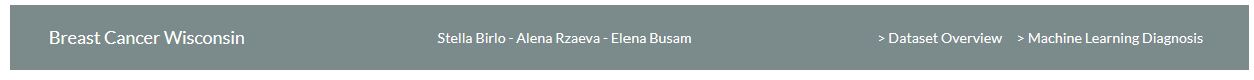

In [137]:
## Dasboard Navigation bar
NavBar =   dbc.Navbar(
        dbc.Container([dbc.NavbarBrand("Breast Cancer Wisconsin", href="https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/data"),
                    html.Div(["Stella Birlo - Alena Rzaeva - Elena Busam"],style={"color" : "white"}),
                    dbc.Nav([
                    dbc.NavItem(dbc.NavLink("> Dataset Overview", href="http://127.0.0.1:11141/", active="exact")),
                    dbc.NavItem(dbc.NavLink("> Machine Learning Diagnosis", href="http://127.0.0.1:14446/", active="exact"))
                        ])
                        ]),color="dark",dark=True,sticky="top",className="mb-2")

In [138]:
# Selected features by feature engineering above
features = [
    'radius_mean', 'perimeter_mean', 'area_mean',
    'compactness_mean', 'concavity_mean', 'concave points_mean',
    'radius_se', 'perimeter_se', 'area_se',
    'radius_worst', 'perimeter_worst', 'area_worst',
    'compactness_worst', 'concavity_worst', 'concave points_worst'
]

### Funktion zum Erstellen der Slider-Reihen
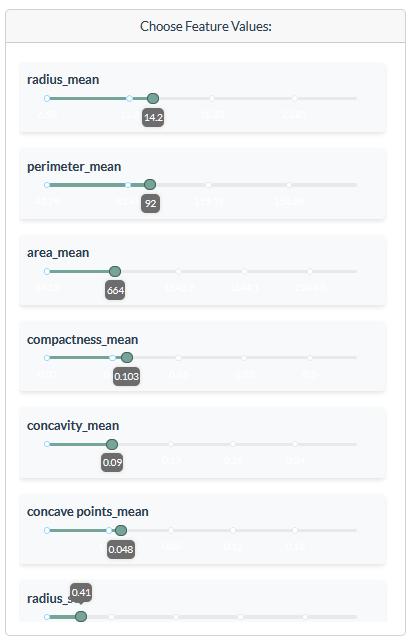

In [140]:
# Funktion zum Erstellen der Slider-Reihen
import numpy as np
def create_slider_rows(features, df, num_columns=1):
    rows = []
    for i in range(0, len(features), num_columns):
        row = html.Div([
            html.Div([
                 html.Label(feature, style={
                    'color': flatly_colors['text'],
                    'fontWeight': 'bold',
                    'marginBottom': '5px'
                }),
                dcc.Slider(
                    id=feature,
                    min=df[feature].min(),
                    max=df[feature].max(),
                    value=df[feature].mean(),
                    marks={i: {'label': str(round(i,2)), 'style': {'color': flatly_colors['background']}} 
                           for i in np.arange(df[feature].min(), df[feature].max(), df[feature].max() / 5)},
                    
                    tooltip={"always_visible": True  ,"placement": "bottom" },
                    className='flatly-slider'
                )
            ],
            style={
                'width': f'{100 / num_columns - 2}%', 
                'display': 'inline-block', 
                'padding': '10px',
                'backgroundColor': flatly_colors['light'],
                'borderRadius': '5px',
                'boxShadow': '0 2px 4px rgba(0,0,0,0.1)'
            }) 
            for feature in features[i:i + num_columns]
        ],
         style={'display': 'flex', 'justifyContent': 'space-between', 'marginBottom': '20px'})
        rows.append(row)
    return rows

### ML Model Choice Dropdown
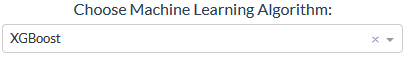

In [142]:
# ML Model Choice Dropdown
model_dd = dcc.Dropdown(
        id='dropdown_ML',
        options=[{'label': v, 'value': v} for v in ['Random Forest','XGBoost',"Neural Network"]],
        value='XGBoost',
        style={'width': '100%', 'margin': '10'}
    )

### # Table funktion for ML model metrics
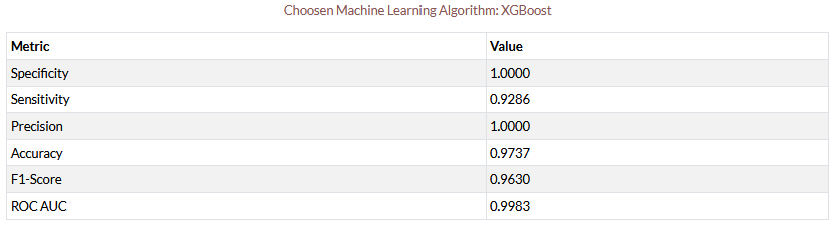

In [144]:
# Table funktion for ML model metrics
def create_metrics_table(metrics):
    return dbc.Table.from_dataframe(
        pd.DataFrame({
            'Metric': ['Specificity', 'Sensitivity', 'Precision', 'Accuracy', 'F1-Score', 'ROC AUC'],
            'Value': [f'{metrics[0]:.4f}', f'{metrics[1]:.4f}', f'{metrics[2]:.4f}', 
                      f'{metrics[3]:.4f}', f'{metrics[4]:.4f}', f'{metrics[5]:.4f}']
        }),
        striped=True,
        bordered=True,
        hover=True,
        responsive=True,
        className='table-sm'
    )

### Table function für ML diagnosis values 
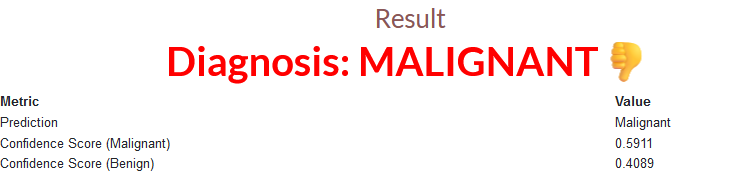

In [152]:
# Table function für ML diagnosis values 
def create_table(data):
    return html.Table([
        html.Thead(html.Tr([html.Th("Metric"), html.Th("Value")])),
        html.Tbody([
            html.Tr([html.Td(metric), html.Td(value)]) for metric, value in data
        ])
    ], style={
        'border-collapse': 'collapse',
        'width': '100%',
        'font-family': 'Arial, sans-serif'
    })

## Dash Page 2: Machine Learning Diagnosis #44446 <a id='page2_dash'></a>

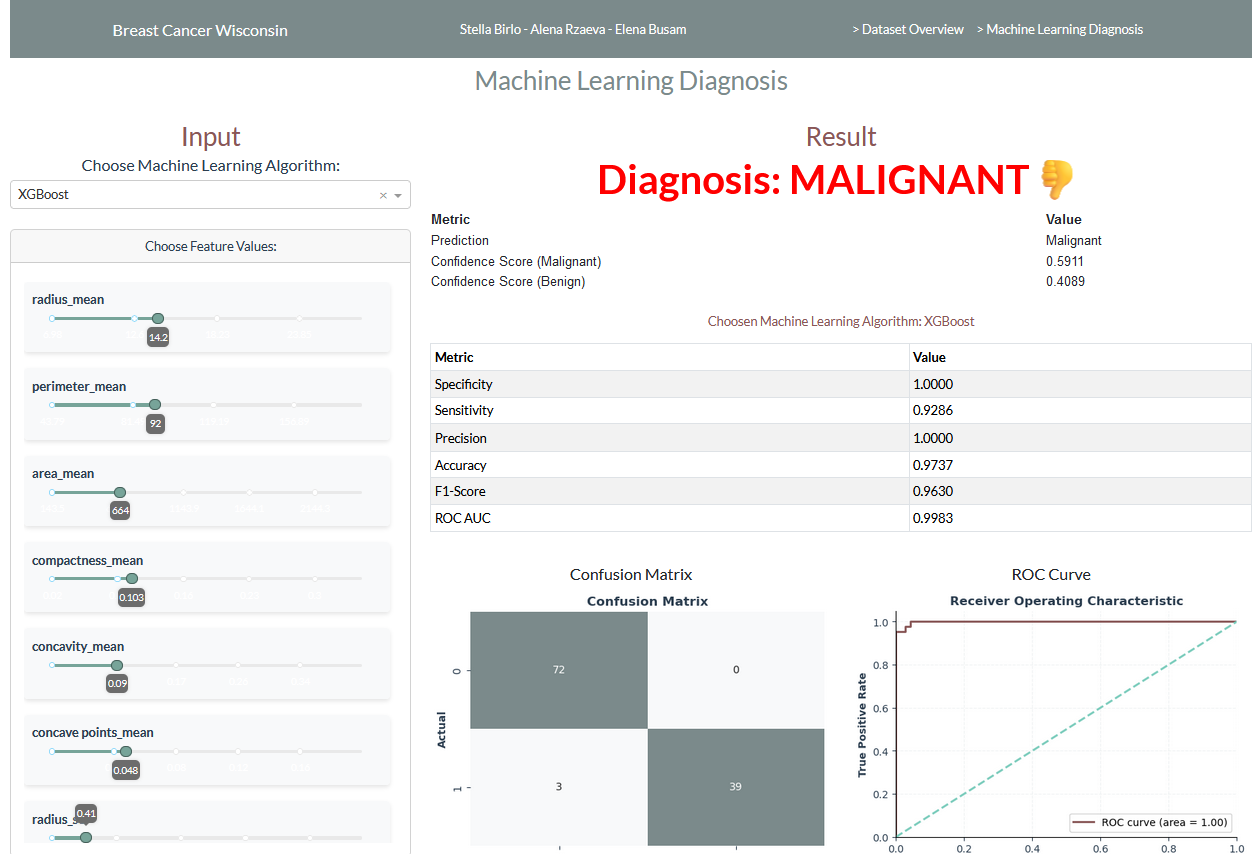

In [156]:
from dash import Dash, html, dcc, callback, Output, Input, dash_table
import plotly.express as px
import dash_bootstrap_components as dbc
import emoji

df = df_cleaned.copy()

app = Dash(external_stylesheets=[dbc.themes.FLATLY])

app.layout = dbc.Container([
    # Navigation bar
     dbc.Row([dbc.Col(NavBar)]),
    
    # Title
    dbc.Row([
        dbc.Col(html.H3("Machine Learning Diagnosis", className="text-center"), style={
            'color': flatly_colors['dark'],
            'padding': '0px',
            'border-radius': '5px',
            'margin-top': '0', 
           'margin-bottom': '0px' 
        })
    ]),
    
    # Main content
    dbc.Row([
        # Left column: ML Algorithm dropdown and Sliders in a scrollable card
        dbc.Col([html.H3("Input", className="text-center mb-1", style={"color":flatly_colors['accent1']}),
        # ML model choice via dropdown
            html.Div([
                html.H5("Choose Machine Learning Algorithm:", className="text-center mb-2", style={"color":flatly_colors['text']}),
                model_dd
            ], className="mb-4"),
            
        # Sliders in a scrollable card for feaure values
            dbc.Card([
                dbc.CardHeader("Choose Feature Values:", className="text-center mb-2", style={"color":flatly_colors['text']}),
                dbc.CardBody([
                    html.Div(
                        create_slider_rows(features, df),
                        style={'height': '700px', 'overflowY': 'auto'}
                    )
                ])
            ])
        ], width=4),  
        
        # Right column: ML Diagnosis result, table and ML model metrics
        dbc.Col([
        # ML Diagnosis result
            html.Div([
                html.H3("Result", className="text-center mb-1", style={"color":flatly_colors['accent1']}),
                html.H2(id='diagnosis-result', className="text-center mb-2")
            ]),
            
        # Results table
            html.Div(id='results-table', className="mb-4"),

        # Machine Learning Algorithm and Metrics header
            html.Div(id='ml-metrics-header', className="mt-4 mb-3"),
        # First row: Metrics table
        dbc.Row([
            dbc.Col([
                html.Div(id='metrics-table')
            ], width=12)
        ], className="mb-4"),
        
        # Second row: Confusion Matrix and ROC Curve side by side
        dbc.Row([
            # Confusion Matrix
            dbc.Col([
                html.H5("Confusion Matrix", className="text-center"),
                html.Img(id='confusion-matrix-plot', className="img-fluid")
            ], width=6),
            
            # ROC Curve
            dbc.Col([
                html.H5("ROC Curve", className="text-center"),
                html.Img(id='roc-curve-plot', className="img-fluid")
            ], width=6)
        ])

        ], width=8)  
    ], className="mt-4"),
], fluid=True, className="px-4 py-2")

#---------------------------------------------------------------
# Callback-Funktion

# Callback for ML Algorithms
@app.callback(
    Output('diagnosis-result', 'children'),
    Output('diagnosis-result', 'style'), 
    Output('results-table', 'children'),
    Input('dropdown_ML', 'value'),
    [Input(feature, 'value') for feature in features]
)
def update_model(selected_model, *values):
    print(f"Selected model: {selected_model}")
    print(f"Input values: {values}")
    
    ft_vals = np.array(values).reshape(1, -1)
    
    try:
        models = {
            "XGBoost": xgb_classifier,
            "Random Forest": rf_classifier,
            "Neural Network": sq_model
        }
        
        model = models.get(selected_model)
        if model is None:
            raise ValueError(f"Invalid model selected: {selected_model}")

        prediction = model.predict(ft_vals)
        confidence_score = model.predict_proba(ft_vals) if selected_model != "Neural Network" else model.predict(ft_vals)

        is_malignant = prediction[0] == 1 if selected_model != "Neural Network" else prediction[0] > 0.5
        
        table_data = [
            ("Prediction", 'Malignant' if is_malignant else 'Benign'),
            ("Confidence Score (Malignant)", f"{confidence_score[0][1]:.4f}" if selected_model != "Neural Network" else f"{confidence_score[0][0]:.4f}"),
            ("Confidence Score (Benign)", f"{confidence_score[0][0]:.4f}" if selected_model != "Neural Network" else f"{1-confidence_score[0][0]:.4f}"),
        ]
        
        table = create_table(table_data)
        
        diagnosis = "MALIGNANT" + emoji.emojize(':thumbs_down:') if is_malignant else "BENIGN" + emoji.emojize(':thumbs_up:')
        diagnosis_color = "red" if is_malignant else "green"
        diagnosis_result = f"Diagnosis: {diagnosis}"
        diagnosis_style = {'color': diagnosis_color, 'fontSize': '50px', 'fontWeight': 'bold'}

        return diagnosis_result, diagnosis_style, table
    
    except Exception as e:
        print(f"Error details: {str(e)}")
        return f"Ein Fehler ist aufgetreten: {str(e)}", {}, None

#--------------------------------------------
# callback für ML Algorithmus Metriken
@app.callback(
    [Output('ml-metrics-header', 'children'),
     Output('metrics-table', 'children'),
     Output('confusion-matrix-plot', 'src'),
     Output('roc-curve-plot', 'src')],
    [Input('dropdown_ML', 'value')]
)
def update_metrics_and_plots(selected_model):
    if selected_model == "XGBoost":
        results = results_xgb
    elif selected_model == "Random Forest":
        results = results_rf
    elif selected_model == "Neural Network":
        results = results_sq
    else:
        return "Invalid model selected", None, None, None

    header = [
        html.Div(f"Choosen Machine Learning Algorithm: {selected_model}", 
                 className="text-center",
                 style={"color":flatly_colors['accent1'],"size":5})
    ]
    
    table = create_metrics_table(results['metrics'])
    
    confusion_matrix_src = f"data:image/png;base64,{results['confusion_matrix_plot']}"
    roc_curve_src = f"data:image/png;base64,{results['roc_curve_plot']}"
    
    return header, table, confusion_matrix_src, roc_curve_src

def create_metrics_table(metrics):
    return dbc.Table.from_dataframe(
        pd.DataFrame({
            'Metric': list(metrics.keys()),
            'Value': [f'{value:.4f}' for value in metrics.values()]
        }),
        striped=True,
        bordered=True,
        hover=True,
        responsive=True,
        className='table-sm'
    )

## Slider Style
app.index_string = '''
<!DOCTYPE html>
<html>
    <head>
        {%metas%}
        <title>{%title%}</title>
        {%favicon%}
        {%css%}
        <style>
            .flatly-slider .rc-slider-track {
                background-color: #77a499;
            }
            .flatly-slider .rc-slider-handle {
                border-color: #435b56;
                background-color: #77a499;
            }
            .flatly-slider .rc-slider-handle:hover {
                border-color: #77a499;
            }
            .flatly-slider .rc-slider-handle:active {
                border-color: #77a499;
                box-shadow: 0 0 5px #1ABC9C;
            }
            .flatly-slider .rc-slider-mark-text {
                color: #7B8A8B;
            }
        </style>
    </head>
    <body>
        {%app_entry%}
        <footer>
            {%config%}
            {%scripts%}
            {%renderer%}
        </footer>
    </body>
</html>
'''
        
       
if __name__ == "__main__":
    app.run_server(debu=True, port=14446, jupyter_mode = "tab")

Dash app running on http://127.0.0.1:14446/


<IPython.core.display.Javascript object>

## Dash Page 1: Data Overview # 11121 <a id='page1_dash'></a>

### Dataset explaination pictures
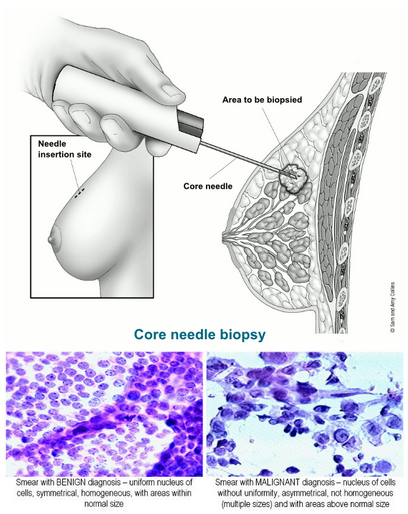

In [160]:
# Dataset explaination pictures

boob2 = "https://www.cancer.org/adobe/dynamicmedia/deliver/dm-aid--462f5161-c25f-4beb-877b-25f2aa61c3ac/core-needle-biopsy.gif?quality=82&preferwebp=true&width=1440"
Zell_Bild_Link = "https://www.researchgate.net/publication/232811011/figure/fig3/AS:214220353347586@1428085520095/Captured-images-of-layers-of-glass-with-smears-of-breast-mass-obtained-by-FNA-the-parts.png"
b_pic =  html.Img(src=boob2,width=400)
c_pic =  html.Img(src=Zell_Bild_Link,width=400)
     

### Card to choose X und Y for scatter plot
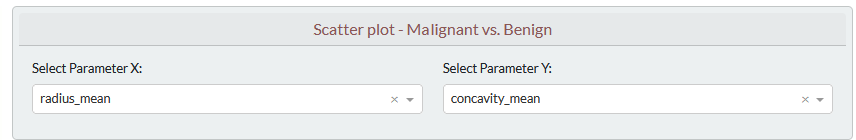

In [163]:
# Card to choose X und Y for scatter plot 
control = dbc.Card([
    dbc.CardHeader(
        html.H5("Scatter plot - Malignant vs. Benign", className="text-center mb-0",style={"color":flatly_colors['accent1']})
    ),
    dbc.CardBody([
        dbc.Row([
            dbc.Col([   
                dbc.Label("Select Parameter X:", className="font-weight-bold"),
                dcc.Dropdown(
                    id="select_parameter_x",
                    value="radius_mean",
                    options=[{"label": i, "value": i} for i in df.iloc[:,1:].columns],
                    className="mb-2"
                ),
            ], md=6),
            dbc.Col([
                dbc.Label("Select Parameter Y:", className="font-weight-bold"),
                dcc.Dropdown(
                    id="select_parameter_y",
                    value="concavity_mean",
                    options=[{"label": i, "value": i} for i in df.iloc[:,1:].columns],
                    className="mb-2"
                ),
            ], md=6)
        ])
    ])
],  className="p-2", color="light")


### filterable table of dataset
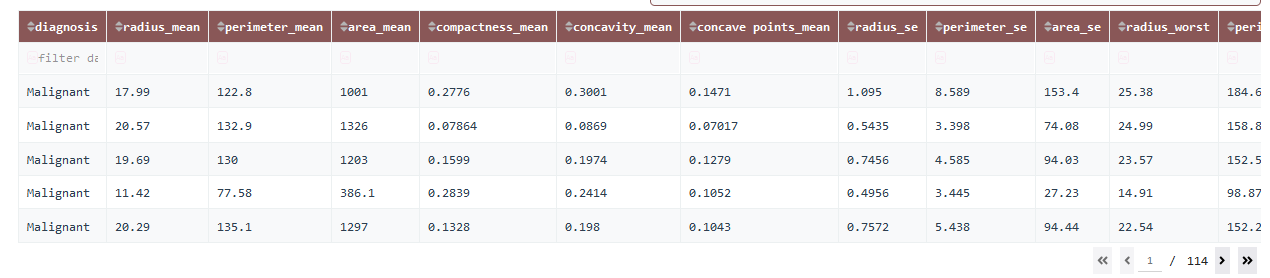

In [166]:
# filterable table of dataset
dff = df_cleaned.copy()
df_table = dash_table.DataTable(
                id='dataset-table',
                columns=[{"name": i, "id": i} for i in dff.columns],
                data=dff.to_dict('records'),
                page_size=5, 
                sort_mode='multi',
                selected_rows=[],
                style_table={'overflowX': 'auto'},
                style_header={
                    'backgroundColor': flatly_colors['accent1'],
                    'color': 'white',
                    'fontWeight': 'bold'
                },
                style_cell={
                    'backgroundColor': flatly_colors['light'],
                    'color': flatly_colors['text'],
                    'border': f'1px solid {flatly_colors["grid"]}',
                    'padding': '10px',
                    'textAlign': 'left'
                },
                style_data_conditional=[
                    {
                        'if': {'row_index': 'odd'},
                        'backgroundColor': flatly_colors['background']
                    }
                ],
                sort_action='native',  
                filter_action='native', 
                page_action='native',  
            )

### Scatter Plot Test

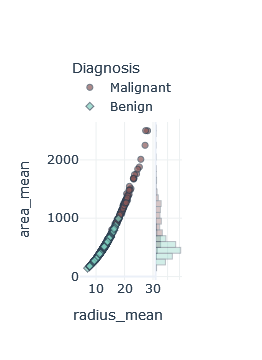

In [169]:
# Scatter Plot Test
xx = "radius_mean"
yy = "area_mean"
dff["diagnosis"] = dff["diagnosis"].replace({0: "Benign", 1: "Malignant"})
    
color_discrete_map = {'Malignant': flatly_colors['accent1'], 'Benign': flatly_colors['accent2']}
scat_fig = px.scatter(dff, x=xx, y=yy, color="diagnosis", symbol="diagnosis",
                          template="flatly_custom",
                          marginal_x="histogram", marginal_y="histogram",
                          color_discrete_map=color_discrete_map)

scat_fig.update_layout(
        legend=dict(orientation="v", yanchor="bottom", y=0.72, xanchor="right", x=0.92, title="Diagnosis"),
        xaxis_title=str(xx),
        yaxis_title=str(yy),
        dragmode='select'
    )

scat_fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color=flatly_colors['text'])))

### Reset button for table
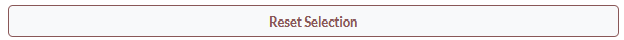

In [172]:
# reset button for table
reset_button = html.Button(
    'Reset Selection', 
    id='reset-button_tab', 
    n_clicks=0,
    className='btn btn-primary',
    style={
        'backgroundColor': flatly_colors['light'],
        'borderColor': flatly_colors['accent1'],
        'color': flatly_colors['accent1'],
        'fontWeight': 'bold',
        'marginBottom': '5px',
        'marginTop': '5px',
        'width': '100%',  # Setzt die Breite auf 50% des Elternelements
        'display': 'block',  # Macht den Button zu einem Block-Element
        'marginLeft': 'auto',  # Zentriert den Button
        'marginRight': 'auto'  # Zentriert den Button
    }
)


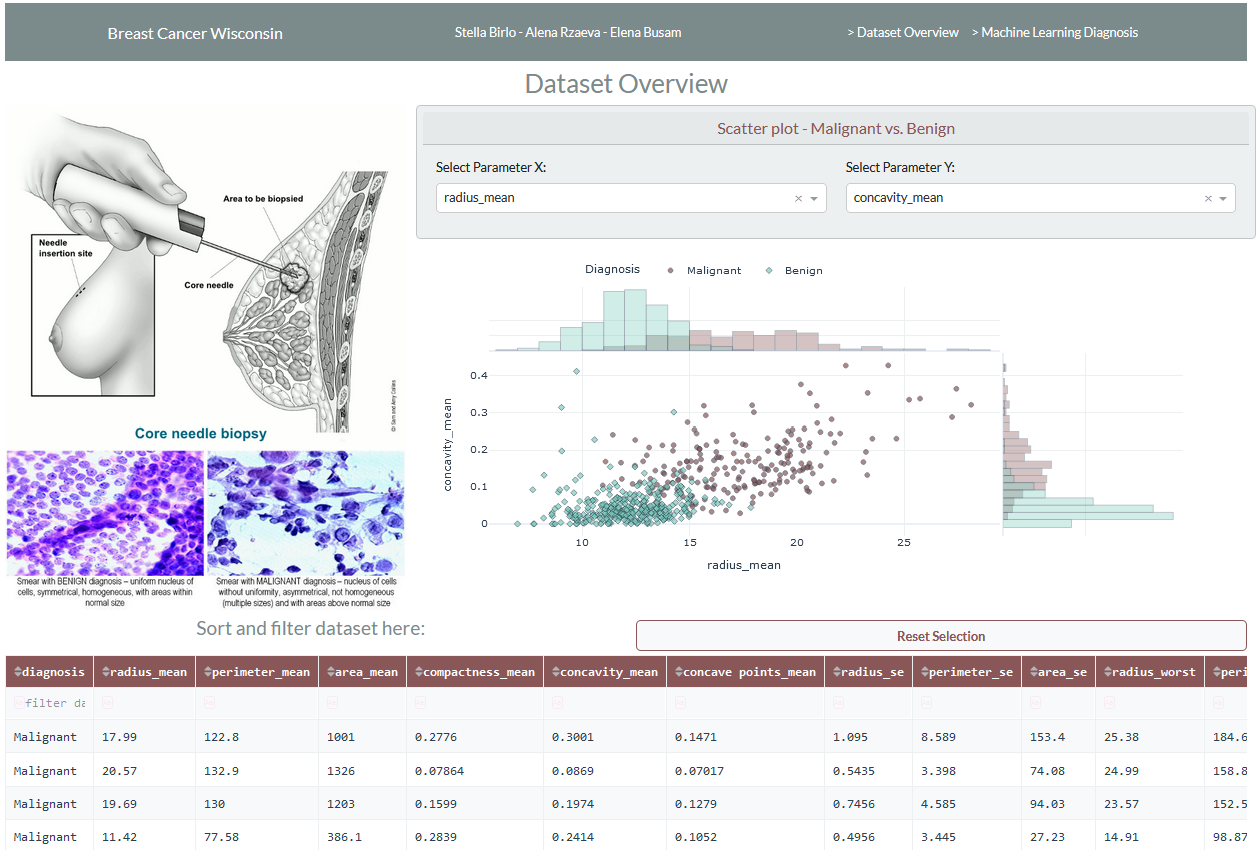

In [175]:
df = df_cleaned.copy()
dff = df.copy()
dff["diagnosis"] = dff["diagnosis"].replace({0: "Benign", 1: "Malignant"})
app = Dash(external_stylesheets=[dbc.themes.FLATLY])

app.layout = dbc.Container([
    # Naviation bar
    dbc.Row([dbc.Col(NavBar)]),
    # Title
    dbc.Row(html.H3("Dataset Overview", className="text-center"), style={
            'color': flatly_colors['dark'],
            'padding': '0px',
            'border-radius': '5px',
            'margin-top': '0', 
           'margin-bottom': '0px' 
        }),
    # Main
    dbc.Row([    
        # Picures on left side
        dbc.Col([
                dbc.Row([b_pic,c_pic])], width=4),
        # X/Y-Card and Scatter plot on right side
        dbc.Col([
                dbc.Row([control,
                dcc.Graph(id="scat-plot", selectedData=None)
                        ])
                ])
                ], className="mb-2"),
    # Bottom table of dataset
    dbc.Row([ 
        dbc.Col([
        html.H4("Sort and filter dataset here:", className="text-center", style={
            'color': flatly_colors['dark'],
            'padding': '0px',
            'border-radius': '1px',
            'margin-top': '0', 
           'margin-bottom': '3px'})
        ]),
        dbc.Col([
        reset_button
        ]),
        df_table
        ])
    
], fluid=True, className="px-4 py-2")

#------------------------------------------------------------------
# Callback-Funktion

# Callback for scatter plot
@app.callback(
    Output('scat-plot', 'figure'),
    Input('select_parameter_x', 'value'),
    Input('select_parameter_y', 'value')
)
def update_graph(x_param, y_param):
    dff = df.copy()
    dff["diagnosis"] = dff["diagnosis"].replace({0: "Benign", 1: "Malignant"})
    xx = x_param
    yy = y_param
    color_discrete_map = {'Malignant': flatly_colors['accent1'], 'Benign': flatly_colors['accent2']}
    scat_fig = px.scatter(dff, x=xx, y=yy, color="diagnosis", symbol="diagnosis",
                          template="flatly_custom",
                          marginal_x="histogram", marginal_y="histogram",
                          color_discrete_map=color_discrete_map)

    scat_fig.update_layout(
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=0.5, title="Diagnosis"),
        xaxis_title=str(xx),
        yaxis_title=str(yy),
        dragmode='select' 
    )

    scat_fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color=flatly_colors['text'])))
    return scat_fig


# Callback for table filters
@app.callback(
    Output('dataset-table', 'data'),
    Input('scat-plot', 'selectedData'),
    Input('select_parameter_x', 'value'),
    Input('select_parameter_y', 'value')
)
def update_table(selectedData, x_param, y_param):
    dff = df.copy()
    dff["diagnosis"] = dff["diagnosis"].replace({0: "Benign", 1: "Malignant"})
    
    if selectedData and selectedData['points']:
        points = selectedData['points']
        filtered_indices = [p['pointIndex'] for p in points]
        filtered_df = dff.iloc[filtered_indices]
    else:
        filtered_df = dff

    return filtered_df.to_dict('records')
    
# Callback for table filters reset button
@app.callback(
    Output('scat-plot', 'selectedData'),
    Input('reset-button_tab', 'n_clicks')
)
def reset_selection(n_clicks):
    return None


#------------------------------------------------------------------

if __name__ == "__main__":
    app.run_server(debu=True, port=11141, jupyter_mode = "tab")

Dash app running on http://127.0.0.1:11141/


<IPython.core.display.Javascript object>